# Coral Edge TPU tests

* [This Coral TPU project](https://github.com/foobar167/junkyard/tree/master/coral_tpu)

TF and `tflite_runtime` library can not run simultaneously in the same environment.

For this reason run `*_int8_edgetpu.tflite` files for `tflite_runtime` library on Coral Edge TPU in the separate Jupyter Notebook file.

## Helper functions for Coral Edge TPU

In [1]:
# Run TensorFlow Lite model on Coral USB Accelerator or CPU
# Use tflite_runtime library or TF library. Cannot use both in the same environment.

import os
import time
import math
import json
import shutil
import platform
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt


_EDGETPU_SHARED_LIB = {
    'Linux': 'libedgetpu.so.1',
    'Darwin': 'libedgetpu.1.dylib',
    'Windows': 'edgetpu.dll',
}[platform.system()]


TFLITE_RUNTIME = True  # use tflite_runtime or TF
IMAGE_SHAPE = (224, 224, 3)  # do not change it
IMAGE_SHAPE2 = (299, 299, 3)  # do not change it
RESIZE_METHOD = Image.BILINEAR
EXT = (".jpg", ".jpeg", ".png", ".gif")  # valid image file extensions
IMAGENETV2_PATH = "imagenetv2-matched-frequency-format-val"  # path to ImageNet-v2 dataset


# Models dictionary in the format: key: [name, "", norm, shape]
net = {
    "MobileNetV2": ["mobilenetv2_1.0_224",  # v[0] model filename
                    "placeholder",          # v[1] placeholder for variables
                    True,                   # v[2] normalize image or not
                    IMAGE_SHAPE],           # v[3] input image shape

    # There is an error for MobileNetV3Large model during run:
    #     external/ruy/ruy/apply_multiplier.cc:52: RUY_CHECK_LE condition not satisfied: [ shift <= 7 ] with values [ 10 <= 7 ].
    # "MobileNetV3Large": ["mobilenetv3large_1.0_224", "placeholder", False, IMAGE_SHAPE],

    "MobileNetV3Small": ["mobilenetv3small_1.0_224", "placeholder", False, IMAGE_SHAPE],
    "DenseNet121": ["densenet121_224", "placeholder", True, IMAGE_SHAPE],
    "InceptionV3": ["inceptionv3_299", "placeholder", True, IMAGE_SHAPE2],
    "ResNet50": ["resnet50_224", "placeholder", False, IMAGE_SHAPE],    # norm==False, check it for diff. TF
    "ResNet101": ["resnet101_224", "placeholder", False, IMAGE_SHAPE],  # norm==False, check it for diff. TF
    "ResNet50V2": ["resnet50v2_224", "placeholder", True, IMAGE_SHAPE],
    "ResNet101V2": ["resnet101v2_224", "placeholder", True, IMAGE_SHAPE],
    "VGG16": ["vgg16_224", "placeholder", False, IMAGE_SHAPE],          # norm==False, check it for diff. TF
    "Xception": ["xception_299", "placeholder", True, IMAGE_SHAPE2],
}


# TF and tflite_runtime library can not run simultaneously in the same environment.
if TFLITE_RUNTIME:  # use tflite_runtime library
    import tflite_runtime.interpreter as tflite
    load_delegate = tflite.load_delegate
    get_interpreter = tflite.Interpreter
else:  # use TensorFlow library
    import tensorflow as tf
    load_delegate = tf.lite.experimental.load_delegate
    get_interpreter = tf.lite.Interpreter


def get_image_names(path):
    """ Get all image names in a directory and
        return the list of (label, name) """
    dataset = []  # list of (label, name)
    classes = {}  # dict of classes
    for root, dirs, files in os.walk(path, topdown=True):
        for name in files:
            if name.lower().endswith(EXT):
                label = os.path.basename(root)
                name = os.path.join(root, name)
                dataset.append((int(label), name))
                classes[label] = label
    return dataset, classes


def get_images(lst):
    """ Get all images from the list (label, name) and
        return dictoonary of images """
    images = {}
    for label, name in lst:
        if name.lower().endswith(EXT):
            images[name] = Image.open(name).convert("RGB")
    return images


def separator(info=""):
    """ Separator string with information """
    sep1 = "-"
    sep2 = " "
    sep_length = 70  # separator length
    l1 = (sep_length - len(info)) // 2 - len(sep2)  # number of dashes
    if len(info) == 0:
        s = sep1 * sep_length
        return f"{s}"
    elif l1 <= 0:
        return info
    else:
        l2 = (sep_length - len(info)) % 2  # 0 or 1 extra space
        s1 = sep1 * l1
        s2 = info + " " * l2
        return f"{s1}{sep2}{s2}{sep2}{s1}"


def show(images, cmap="viridis"):
    """ Show images with matplotlib. Default color map is "viridis" """
    fig = plt.figure(figsize=(12, 8))  # create figure
    l = len(images)
    rows = math.floor(math.sqrt(l))
    cols = math.ceil(l / rows)
    for i, (key, value) in enumerate(images.items(), 1):
        fig.add_subplot(rows, cols, i)  # add a subplot
        plt.imshow(value, cmap=cmap)
        plt.axis("off")
        plt.title(os.path.basename(key))
    plt.show()


def load_labels(idx=1):
    """ Get ImageNet dataset labels from URL """
    url = "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/imagenet_class_index.json"
    name = os.path.basename(url)
    if not os.path.exists(name):
        output = os.system(f"wget {url} -O {name}")
        if output != 0:
            print(f"Error when downloading URL: {url}")
            return None
    CLASS_INDEX = json.load(open(name))
    labels = []
    for i in range(len(CLASS_INDEX)):
        # CLASS_INDEX example: "753": ["n04040759", "radiator"]
        labels.append(CLASS_INDEX[str(i)][idx])
    return labels


# Create "temp" directory and make it the current dir
TEMP_DIR = "temp"
THIS_DIR = os.path.dirname(os.path.realpath("__file__"))  # path to the current dir
if os.path.basename(THIS_DIR) == TEMP_DIR:  # already in the "temp" directory
    pass
else:
    if not os.path.isdir(TEMP_DIR):  # directory does not exist
        os.makedirs(TEMP_DIR)
    os.chdir(os.path.join(THIS_DIR, TEMP_DIR))  # make path to "temp" dir the current path

## Download the ImageNet-v2 dataset

Can not use `tfds` and other TF libraries, because TF is not compatible with `tflite_runtime` library.

Download the [ImageNet-v2](https://www.tensorflow.org/datasets/catalog/imagenet_v2) dataset manually.

Use [this URL](https://huggingface.co/datasets/vaishaal/ImageNetV2/tree/main) to download the file `imagenetv2-matched-frequency.tar.gz`.

Unarchived manually too. Cannot untar it with `!tar` or `extract()` function.

(0, 'imagenetv2-matched-frequency-format-val\\0\\58fbc3e79ef15162b7726de04e98c90bb91a3055.jpeg')
(0, 'imagenetv2-matched-frequency-format-val\\0\\64f661b97cfd6db73bd6c30325597cf7c7b322d5.jpeg')
(0, 'imagenetv2-matched-frequency-format-val\\0\\66123ec1b806abff544bb89e11653ef5185af4be.jpeg')
(0, 'imagenetv2-matched-frequency-format-val\\0\\7e4a8987a9a330189cc38c4098b1c57ac301713f.jpeg')
(0, 'imagenetv2-matched-frequency-format-val\\0\\8e1374a4e20d7af22665b7749158b7eb9fa3826e.jpeg')
(0, 'imagenetv2-matched-frequency-format-val\\0\\bcf8a5326180b5e9320642f5024096fbc8a5d454.jpeg')


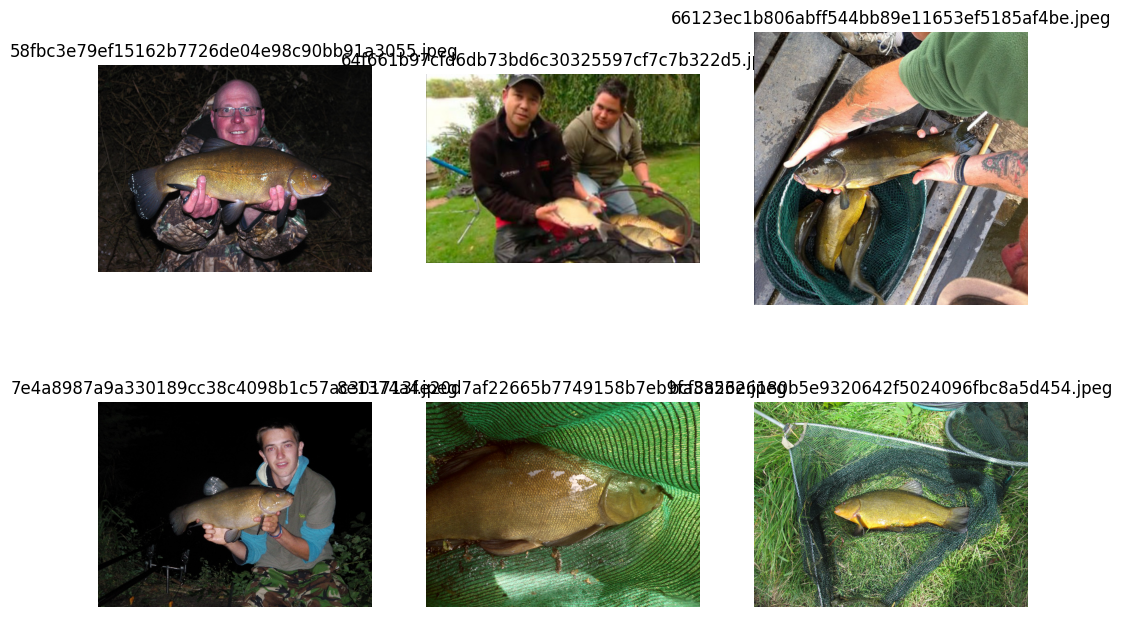

Number of classes: 1000
Number of images: 10000


In [2]:
# Prepare the ImageNet-v2 dataset manually without TF
DS, CLASSES = get_image_names(IMAGENETV2_PATH)

example = DS[:6]
print(*example, sep="\n")
imgs = get_images(example)
show(imgs)  # visualize dataset images
print(f"Number of classes: {len(CLASSES)}")
print(f"Number of images: {len(DS)}")

## Estimate accuracy and speed on ImageNet-v2 dataset

In [3]:
def prepare(datapoint, normalize, im_shape):
    """ Prepare datapoint (label, name) and return (label, image) tuple """
    # Open and resize the image
    img = Image.open(datapoint[1]).resize(im_shape[0:2], RESIZE_METHOD)
    img = np.float32(img)  # convert from uint8 to float32
    if normalize:  # normalize
        img = img / 127.5 - 1.0
    else:  # don't normalize
        pass
    return datapoint[0], img


def evaluate(dataset, model_name, ext="_int8_edgetpu.tflite"):
    """ TFLite model evaluation function """
    model_name += ext  # use "*_int8_edgetpu.tflite" files

    try:  # try to calculate on TPU (or CPU for CPU-model)
        delegate = load_delegate(library=_EDGETPU_SHARED_LIB, options={})
        interpreter = get_interpreter(model_path=os.path.join(TEMP_DIR, model_name),
                                      experimental_delegates=[delegate])
    except ValueError:  # calculate on CPU
        print('Error: can not load delegate. Calculate on CPU')
        interpreter = get_interpreter(model_path=os.path.join(TEMP_DIR, model_name))
    
    interpreter.allocate_tensors()  # allocate memory for the model's input tensors

    # Use input and output details to get info about model parameters
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # # Visualize in/out details. Uncomment for debug purposes
    # print(f"\n" f"input_details:")
    # for k, v in input_details.items():
    #     print(f"{k} => {v}")
    # print(f"\n" f"output_details:")
    # for k, v in output_details.items():
    #     print(f"{k} => {v}")
    # print()

    params = input_details["quantization_parameters"]
    scale, zero_point = params["scales"], params["zero_points"]
    dtype = input_details["dtype"]  # float32 or int for quantized model

    # De-quantization is not necessary, because took max value without accuracy
    quant = False  # quantization
    if scale.size == 0 or zero_point.size == 0:
        pass
    else:
        # print("quantization - yes")
        quant = True

    true_labels = []
    predictions = []
    total = len(dataset)
    start_time = time.time()
    for i, (label, img) in enumerate(dataset):
        if i % 100 == 0:
            print(f"\r" f"Evaluated {i} from {total}",
                  f" in {time.time() - start_time} sec", end="")

        # Image dataset can go through quantization before running inference:
        #     quantization: q = f / scale + zero_point
        if quant:
            img = img / scale + zero_point
            np.clip(img, 0, 255, out=img)  # clip values to [0, 255]

        img = np.array(img, dtype=dtype)  # convert to necessary type
        img = np.expand_dims(img, axis=0)  # [224, 224, 3] to [1, 224, 224, 3]
        interpreter.set_tensor(input_details["index"], img)
        interpreter.invoke()  # predict
        results = interpreter.tensor(output_details["index"])().flatten()
        i = np.argmax(results)
        predictions.append(i)
        true_labels.append(label)

    print("\r", end="")
    del interpreter
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    accuracy = (predictions == true_labels).mean() * 100  # get accuracy in %
    runtime = time.time() - start_time  # runtime in seconds
    print(f"Accuracy: {accuracy:.1f} %; time: {runtime:.1f} sec" f"\n")

In [4]:
# Run short preliminary tests
def performance_tests(n):
    start_time = time.time()
    
    for k, v in net.items():
        # Example:
        #     d = [(1, "one"), (2, "two"), (3, "three")]
        #     def prepare(kv): return (kv[0], f"{kv[1]}-ok")
        #     data = list(map(lambda kv: prepare(kv), d[:2]))
        #     data --> [(1, 'one-ok'), (2, 'two-ok')]
        dataset = list(map(lambda kv: prepare(kv, v[2], v[3]), DS[:n]))
        print(separator(v[0]))
        evaluate(dataset, v[0])
    
    stop_time = time.time()
    print(f"Runtime: {(stop_time - start_time):.0f} seconds")


performance_tests(50)

------------------------ mobilenetv2_1.0_224  ------------------------
Accuracy: 68.0 %; time: 1.2 s

---------------------- mobilenetv3small_1.0_224 ----------------------
Accuracy: 38.0 %; time: 32.5 s

-------------------------- densenet121_224  --------------------------
Accuracy: 8.0 %; time: 7.6 s

-------------------------- inceptionv3_299  --------------------------
Accuracy: 84.0 %; time: 37.4 s

---------------------------- resnet50_224 ----------------------------
Accuracy: 0.0 %; time: 34.5 s

--------------------------- resnet101_224  ---------------------------
Accuracy: 0.0 %; time: 68.9 s

--------------------------- resnet50v2_224 ---------------------------
Accuracy: 72.0 %; time: 35.0 s

-------------------------- resnet101v2_224  --------------------------
Accuracy: 74.0 %; time: 71.6 s

----------------------------- vgg16_224  -----------------------------
Accuracy: 0.0 %; time: 240.9 s

---------------------------- xception_299 ----------------------------
Accurac

* Runtime ≈ ??? hours for Desktop
* Runtime ≈ ??? hours for CoolPi
* Runtime ≈ ??? hours for Pi4

In [6]:
%%script echo "Skip this cell."

# Run on ImageNet-v2 10000 images
performance_tests(len(DS))

Skip this cell.
